#HW6: Variational Autoencoder
In this homework, we will explore how to develop a Variational Autoencoder (VAE). As a dataset, we will use the MNIST dataset.
In developing the VAE we also explore how to develop an ad-hoc layer and a nonstandard training step.


##Load data
We load the MNIST dataset, using tf.keras.datasets. We will use the same code used in HW5.

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the Encoder, and the Decoder.
Let's start by the Encoder that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define the Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class tf.keras.layers that is used as base class for all the layers defined in Keras. Specifically, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[To complete]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method.


In [10]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #[TO COMPLETE] compute and return z
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the encoder. Let's use 3 dense layers (similarly to what we did in HW5), and then use the obtained encoding to compute z_mean and z_var, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the latent_dim (that is the dimension of $z$) to 2. This choice is made to make possible to represent the results easily.

#**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model z_mean and z_var. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. (Insert motivations about your choice into cells immediately below this one.)


In [11]:
latent_dim = 2

encoder_inputs = tf.keras.layers.Input(shape=(784,))
x = tf.keras.layers.Dense(128, activation='tanh')(encoder_inputs)               #[TO COMPLETE]
x = tf.keras.layers.Dense(64, activation='tanh')(x)                                                     
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)                    #[TO COMPLETE] Hint: size would be = latent_dim
z_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)                  #[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          100480      input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 64)           8256        dense_5[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            130         dense_6[0][0]                    
____________________________________________________________________________________________

###Encoder:
Motivating my choices regarding the number of layers, size of layers, and activation function used in each layer.

The number of layers was predefined to be three, although by experimenting on a different number of layers, we can understand that if we add extra layers, the loss and reconstruction loss decreases, whereas the regularization loss Kl increases due to more model complexity. Removing a layer means higher losses and less complexity which makes the regularization loss lower.

The layer sizes affect the number of trainable parameters which in turn has a direct impact on the amount of time each epoch costs, with five times the amount of params, we get a result of 27.47 loss and 23.4 reconstruction loss. This hyperparameter is highly dependent on the amount of time we want to spend training the model. 

The activation functions are sigmoid, relu, and tanh because our problem is categorical. We define a grid search for trying these functions at the end tanh performs slightly better than relu and sigmoid performs the worst.

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. 2 layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

#**[TO COMPLETE]**: define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer).

In [12]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(64, activation='tanh')(latent_inputs) #[TO COMPLETE]
x = tf.keras.layers.Dense(128, activation='tanh')(x)
decoder_outputs = tf.keras.layers.Dense(784, activation='sigmoid' )(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 784)               101136    
Total params: 109,648
Trainable params: 109,648
Non-trainable params: 0
_________________________________________________________________


###Decoder:

For what concerns the decoder in choice of the number of layers, layer sizes, and activation functions. 

In the decoder part, we have to be consistent in our choices with the encoder part.
For example, the number of layers should be the same as the encoder part. The layer sizes and their order should also match and even activation functions except the last layer activation function sigmoid forces the output to the range [0, 1].
In this case, it's not because we want to interpret the output as a probability, rather it's done to force the output to be interpreted as pixel intensity of a greyscale image. Also, the softmax function does not make sense here because it only shows probability.

##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)

            reconstruction_loss = tf.math.reduce_mean(tf.math.reduce_sum(tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(-1)))

            kl_loss = -0.5 * (1 + z_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_var))
            kl_loss = tf.math.reduce_mean(tf.math.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
391/391 [==============================] - 2s 3ms/step - loss: 36.9490 - reconstruction_loss: 35.4759 - kl_loss: 1.4731
Epoch 2/30
391/391 [==============================] - 1s 3ms/step - loss: 32.3857 - reconstruction_loss: 31.4787 - kl_loss: 0.9070
Epoch 3/30
391/391 [==============================] - 1s 3ms/step - loss: 31.9853 - reconstruction_loss: 30.9810 - kl_loss: 1.0042
Epoch 4/30
391/391 [==============================] - 1s 3ms/step - loss: 31.3572 - reconstruction_loss: 29.9259 - kl_loss: 1.4313
Epoch 5/30
391/391 [==============================] - 1s 3ms/step - loss: 30.3802 - reconstruction_loss: 28.3101 - kl_loss: 2.0701
Epoch 6/30
391/391 [==============================] - 1s 3ms/step - loss: 29.9948 - reconstruction_loss: 27.6962 - kl_loss: 2.2987
Epoch 7/30
391/391 [==============================] - 1s 3ms/step - loss: 29.6936 - reconstruction_loss: 27.2038 - kl_loss: 2.4898
Epoch 8/30
391/391 [==============================] - 1s 3ms/step - loss: 29.4272 -

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

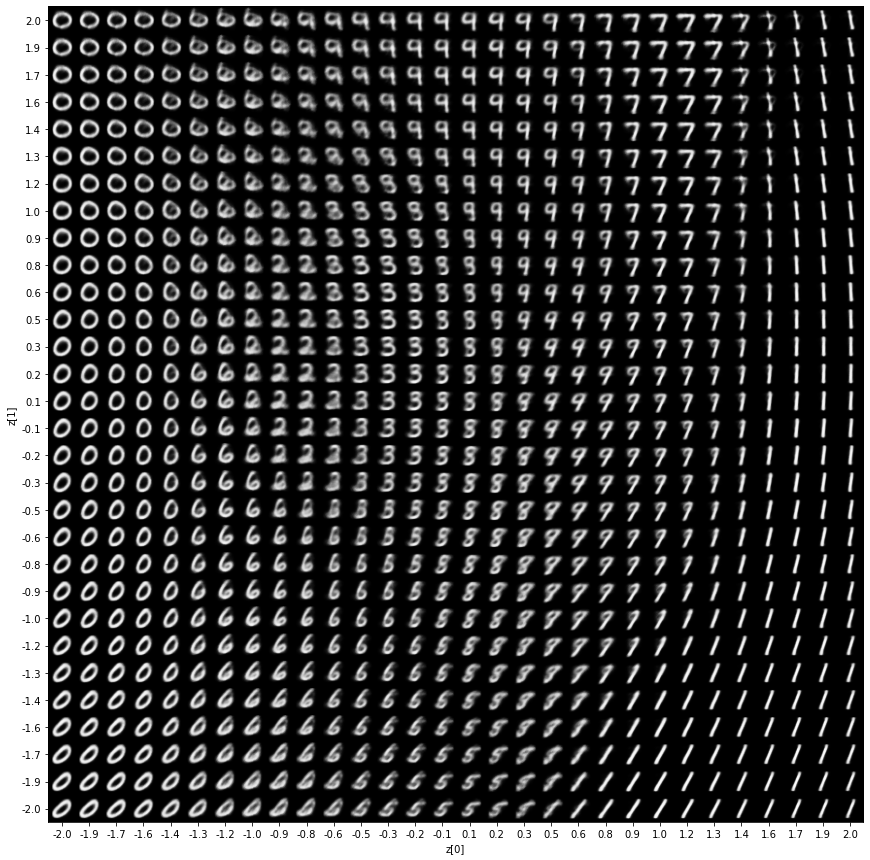

In [15]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

#[TO COMPLETE] explore with different "scale"
# Different scales exploring tells us that bigger scales have more difference in represented digits 
# and smaller ones usually represent more closely structured digits.

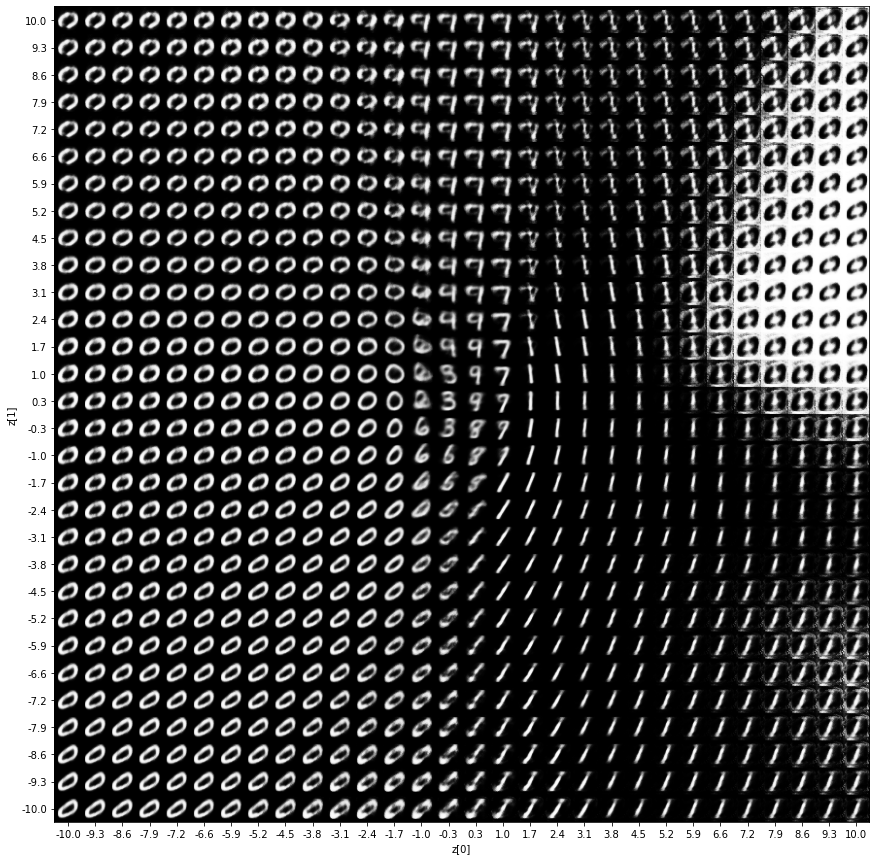

In [18]:
#[TO COMPLETE] explore with different "scale"
# Different scales exploring tells us that bigger scales have more difference in represented digits 
# and smaller ones usually represent more closely structured digits.
plot_latent(encoder, decoder, 10.0, 30) 

Let's finally check how the various digits have been rapresented in the latent space by the VAE.

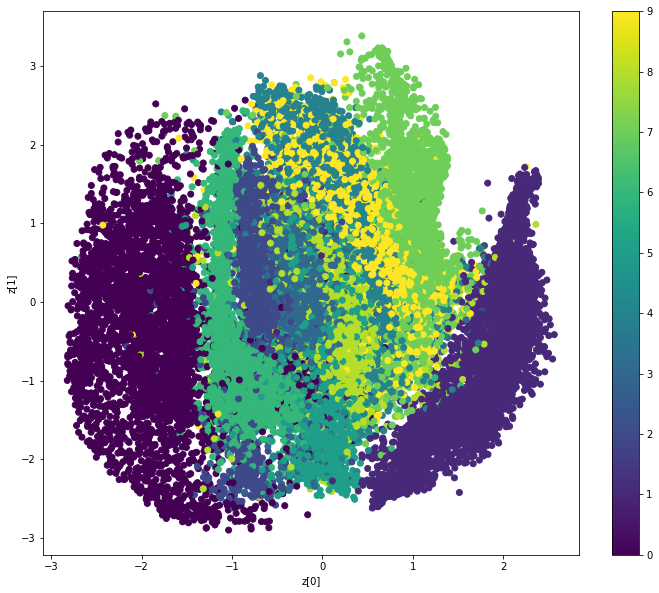

In [17]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

#**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.






This plot is our latent space in two dimensions. Each color represents a number and its neighborhood in this sub-space. These neighborhoods share information in the sense that these digits are structured similarly.

Hyper-parameters can change this visualization dramatically.
Z-mean changes when we change the number of layers, layer sizes, and activation functions. Also, how data is distributed in the distribution is different, and digit neighborhood boundaries can be affected to some extent. 